<a href="https://colab.research.google.com/github/meryemgrimaj/ProjetMLL/blob/main/codes/Projet_ML_knn_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style = "text-align:center">Détection du mildiou de la pomme de terre par imagerie grâce aux méthodes de Machine Learning</h1>

---

# Importation des packages

In [11]:
import pandas as pd
import numpy as np
from PIL import Image
import os

import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc


# Jeu de données

##connection à kaggle

In [12]:
! pip install -q kaggle
! mkdir ~/.kaggle/
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [14]:
! kaggle datasets download -d aarishasifkhan/plantvillage-potato-disease-dataset
! unzip /content/plantvillage-potato-disease-dataset.zip -d dataset_ML

Dataset URL: https://www.kaggle.com/datasets/aarishasifkhan/plantvillage-potato-disease-dataset
License(s): apache-2.0
plantvillage-potato-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/plantvillage-potato-disease-dataset.zip
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: dataset_ML/PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___R

##Importation

In [15]:
# Definition des constantes pour l'importation des images

size = 256
batch_size = 32

# connecter le drive afin d'accéder aux données
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Définition du chemin d'accès
dataset_dir = '/content/dataset_ML/PlantVillage' #dossier global
classe_dir = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'] #dossiers des classes
classe_label = ['Mildiou précoce', 'Mildiou tardif', 'Sain'] # Définition des labels pour les classes

# Importation
data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(size, size),
    batch_size=batch_size
)


Found 2152 files belonging to 3 classes.


Nous avons 2152 images dans ce jeu de données

## Description

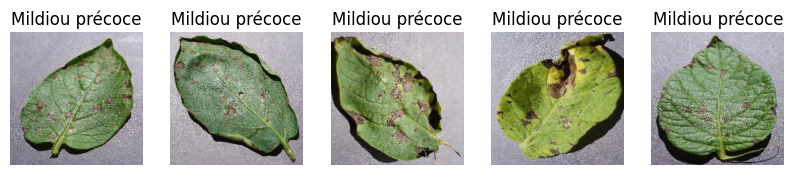

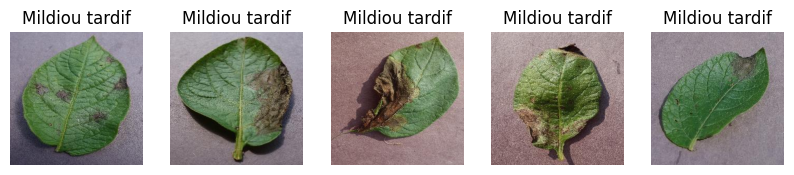

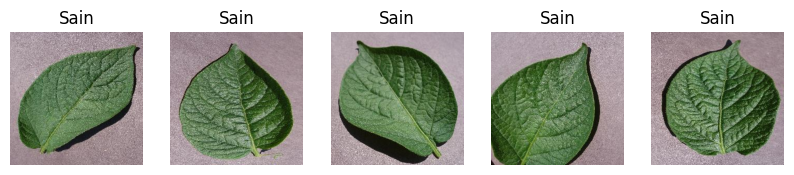

In [ ]:
# Visualisation d'un échantillon d'images pour chaque classes

for k in range(3):
  plt.figure(figsize=(10,10))
  classe = classe_dir[k]
  os.listdir(dataset_dir + '/' + classe)[:5]
  for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(Image.open(dataset_dir + '/' + classe + '/' + os.listdir(dataset_dir + '/' + classe)[i]))
    plt.axis('off')
    plt.title(classe_label[k])
plt.show()


**Les images sont-elles réparties de manière équitable parmi les 3 classes ?**

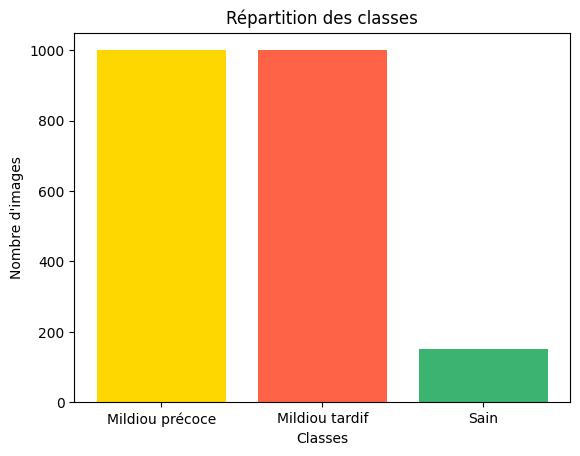

In [ ]:
# Compte par classe
count = []
for classe in classe_dir:
    count.append(len(os.listdir(dataset_dir + '/' + classe)))

# création d'un barplot
plt.bar(classe_label, count, color = ['gold','tomato','mediumseagreen'])
plt.title('Répartition des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.show()

On observe un déséquilibre important des classes dans le jeu de données entre les classes "malade" et la classe sain. Ce déséquilibre peut entraîner un biais important dans notre modèle. Pour y palier nous utilisons donc la technique de suréchantillonage de la classe minoritaire (Technique SMOTE).


# Prétraitement des images


*   redimensionnement des images en (150*150) avec 3 canaux de couleur
*   Donnés applaties en un tableau 1D



In [ ]:
target = []
flat_data_arr = []
for label, i in enumerate(classe_dir):
  print("loading category : {", i, "}")
  path = os.path.join(dataset_dir,i)
  for j in os.listdir(path):
    img_array = imread(os.path.join(path,j))
    img_resize = resize(img_array,(150,150,3))
    #flat_data_arr = img_resize.flatten()
    flat_data_arr.append(img_resize.flatten())
    target.append(label)
  print(f"loaded category:{i} successfully")
flat_data = np.array(flat_data_arr)
target = np.array(target)

loading category : { Potato___Early_blight }
loaded category:Potato___Early_blight successfully
loading category : { Potato___Late_blight }
loaded category:Potato___Late_blight successfully
loading category : { Potato___healthy }
loaded category:Potato___healthy successfully


In [ ]:
print(target.shape)
print(flat_data.shape)

(2152,)
(2152, 67500)


## Données converties en DataFrame puis divisé en x et y

In [ ]:
df2 = pd.DataFrame(flat_data)
df2['Target'] = target
x=df2.iloc[:,:-1]
y=df2.iloc[:,-1]

## Division des données pour l'entrainement et le test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) #reproductibilité

## Application de la technique SMOTE

In [ ]:
smote = SMOTE(sampling_strategy='minority',  #  équilibrer la classe minoritaire
              random_state=42) # reproductibilité
X_train, y_train = smote.fit_resample(X_train, y_train)


Main

(2410, 67500)
(2410,)
[[  0 804]
 [  1 802]
 [  2 804]]


Text(0, 0.5, "Nombre d'images")

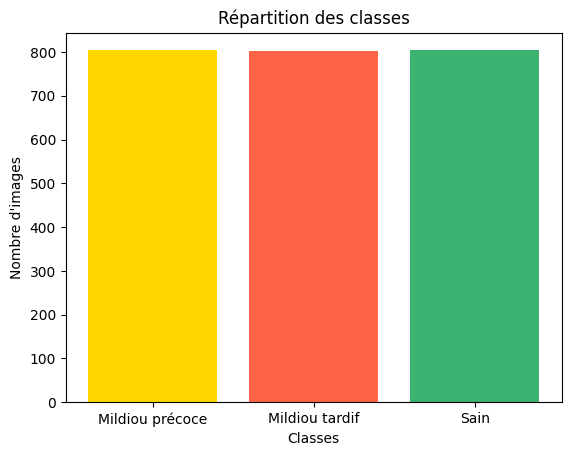

In [ ]:
# taille du jeu de données d'entrainement
print(X_train.shape)
print(y_train.shape)

# répartition des classes dans le jeu de données d'entrainement
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

# barplot
plt.bar(classe_label, counts, color = ['gold','tomato','mediumseagreen'])
plt.title('Répartition des classes')
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')

Maintenant que le jeu de données est prétraité, on applique plusieurs modèle de classification sur le jeu d'entrainement

# KNN

In [ ]:
# Définir le modèle KNN
knn = KNeighborsClassifier()

# Définir les paramètres à tester
param_grid = {
    'n_neighbors': np.arange(1, 15, 2),  # Tester les valeurs impaires de 1 à 10
    'metric': ['manhattan']  # distance manhattan adapté aux grandes dimensions
}

# Créer un GridSearchCV
grid_search = GridSearchCV(knn,
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=1)

# Ajuster le modèle avec les données d'entraînement
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleure précision : ", grid_search.best_score_)

# Utiliser le meilleur modèle pour prédire sur l'ensemble de validation
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(X_test)

# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test, y_test_pred))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_test_pred))

#Fitting 5 folds for each of 15 candidates, totalling 75 fits
#/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
#  _data = np.array(data, dtype=dtype, copy=copy,
#Meilleurs paramètres :  {'metric': 'manhattan', 'n_neighbors': 1}
#Meilleure précision :  0.7889753700505999
##
##Rapport de classification :
#               precision    recall  f1-score   support
#
#           0       0.99      0.62      0.76       196
#           1       0.70      0.79      0.74       198
#           2       0.31      0.73      0.44        37
#
#    accuracy                           0.71       431
#   macro avg       0.67      0.71      0.65       431
#weighted avg       0.80      0.71      0.72       431
#
#
#Matrice de confusion :
# [[121  57  18]
# [  0 156  42]
# [  1   9  27]]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres :  {'metric': 'manhattan', 'n_neighbors': 1}
Meilleure précision :  0.787551867219917

Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.62      0.76       196
           1       0.70      0.78      0.74       198
           2       0.31      0.73      0.43        37

    accuracy                           0.70       431
   macro avg       0.67      0.71      0.64       431
weighted avg       0.80      0.70      0.72       431


Matrice de confusion :
 [[121  57  18]
 [  0 155  43]
 [  1   9  27]]



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.62      0.76       196
           1       0.70      0.78      0.74       198
           2       0.31      0.73      0.43        37

    accuracy                           0.70       431
   macro avg       0.67      0.71      0.64       431
weighted avg       0.80      0.70      0.72       431



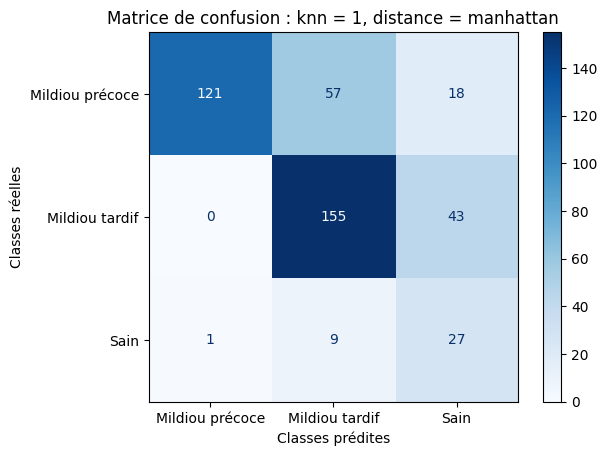

TFP :  0.1548223350253807
TFN :  0.2702702702702703


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)


# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test, y_test_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classe_label)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion : knn = 1, distance = manhattan')
plt.show()

# calcul de faux négatif (= prédit sain) faux négatif / (faux négatif + vrai positifs)
TFP = (cm[0,2] + cm[1,2])/(cm[0,2] + cm[1,2] + cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
# calcul de faux positif (= prédit mildiou) faux positif/ (faux positifs + vrai négatifs)
TFN = (cm[2,0] + cm[2,1])/(cm[2,0] + cm[2,1]+ cm[2,2])
print("TFP : ", TFP)
print("TFN : ", TFN)

Étant donné que nous avons une bonne distinction entre les deux classes de Mildiou, on réalise deux modèles différents plutôt que de les regrouper entre les deux classes.

Modèle de classification avec Mildiou tardif et Sain
Modèle de classification avec Mildiou précoce et sain


Rapport de classification :
               precision    recall  f1-score   support

           1       0.94      0.78      0.85       198
           2       0.39      0.73      0.50        37

    accuracy                           0.77       235
   macro avg       0.66      0.76      0.68       235
weighted avg       0.85      0.77      0.80       235



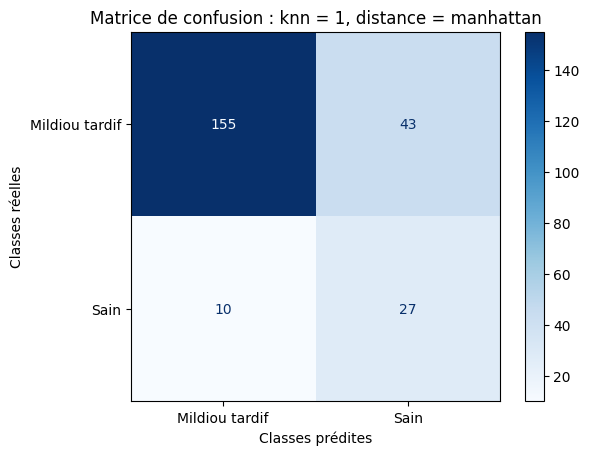

In [ ]:
# knn en retirant la classe 0
X_train1 = X_train[y_train != 0]
y_train1 = y_train[y_train != 0]
X_test1 = X_test[y_test != 0]
y_test1 = y_test[y_test != 0]

knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train1, y_train1)
y_test_pred = knn.predict(X_test1)


# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test1, y_test_pred))

# Matrice de confusion
cm = confusion_matrix(y_test1, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mildiou tardif","Sain"])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion : knn = 1, distance = manhattan')
plt.show()



Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       196
           2       0.51      0.97      0.67        37

    accuracy                           0.85       233
   macro avg       0.75      0.90      0.79       233
weighted avg       0.92      0.85      0.87       233



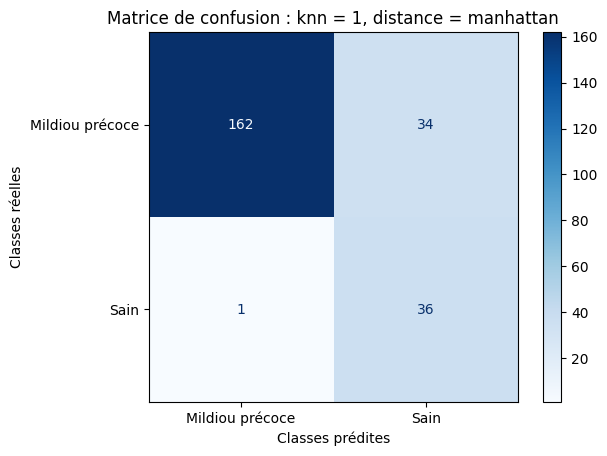

In [ ]:
# knn en retirant la classe 1
X_train0 = X_train[y_train != 1]
y_train0 = y_train[y_train != 1]
X_test0 = X_test[y_test != 1]
y_test0 = y_test[y_test != 1]

knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train0, y_train0)
y_test_pred = knn.predict(X_test0)


# Évaluer le modèle
print("\nRapport de classification :\n", classification_report(y_test0, y_test_pred))

# Matrice de confusion
cm = confusion_matrix(y_test0, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mildiou précoce","Sain"])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Classes prédites')
plt.ylabel('Classes réelles')
plt.title('Matrice de confusion : knn = 1, distance = manhattan')
plt.show()

# Modèle de régression logistique

On utilise ici la méthode one-vs-all. Étant donné que nous avons une bonne distinction entre les deux classes de Mildiou, on réalise deux modèles différents plutôt que de les regrouper entre les deux classes.
1. Modèle de classification avec Mildiou tardif et Sain
2. Modèle de classification avec Mildiou précoce et sain

Précision du modèle de régression logistique : 0.9319148936170213

Rapport de classification :
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        37
           1       0.95      0.96      0.96       198

    accuracy                           0.93       235
   macro avg       0.88      0.86      0.87       235
weighted avg       0.93      0.93      0.93       235



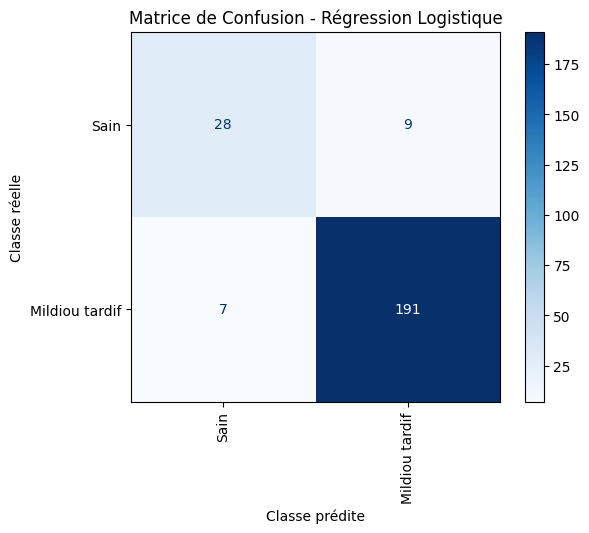

In [ ]:
# Retirer la classe 0 du jeu de données
X_train1 = X_train[y_train != 0]
y_train1 = y_train[y_train != 0]
X_test1 = X_test[y_test != 0]
y_test1 = y_test[y_test != 0]
# Normaliser les données d'entrainement et de validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test1)

# Créer des étiquettes binaires pour la méthode un contre tous
y_train_binary = np.where(y_train1 == 2, 0, 1)
y_test_binary = np.where(y_test1 == 2, 0, 1)

# Créer un modèle de régression logistique
model_rl = LogisticRegression(max_iter=200)  # Augmenter le nombre d'itérations

# Entraîner le modèle
model_rl.fit(X_train_scaled, y_train_binary)

# Prédire sur l'ensemble de validation
y_test_pred = model_rl.predict(X_test_scaled)

# Évaluer la précision
accuracy = accuracy_score(y_test_binary, y_test_pred)
print("Précision du modèle de régression logistique :", accuracy)

# Afficher le rapport de classification
print("\nRapport de classification :\n", classification_report(y_test_binary, y_test_pred))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Sain','Mildiou tardif' ])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Matrice de Confusion - Régression Logistique")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


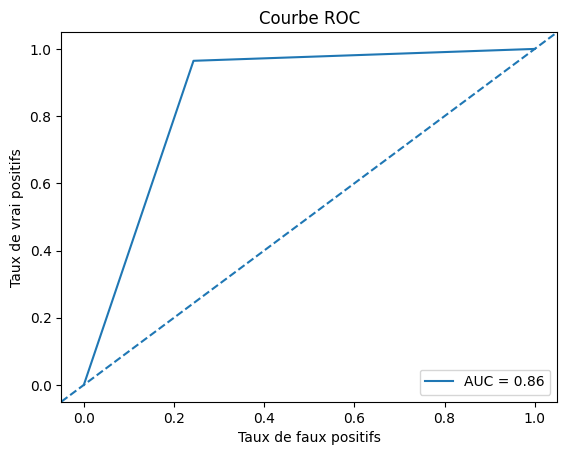

TFP :  [0.         0.24324324 1.        ]


In [ ]:
# AUC avec mildiou tardif/sain
fpr,tpr,_=roc_curve(y_test_binary,y_test_pred)
roc_auc=auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc)
plt.axline((0,0),slope=1,linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()
print("TFP : ", fpr)


Précision du modèle de régression logistique : 0.9914163090128756

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        37
           1       0.99      1.00      0.99       196

    accuracy                           0.99       233
   macro avg       0.99      0.97      0.98       233
weighted avg       0.99      0.99      0.99       233



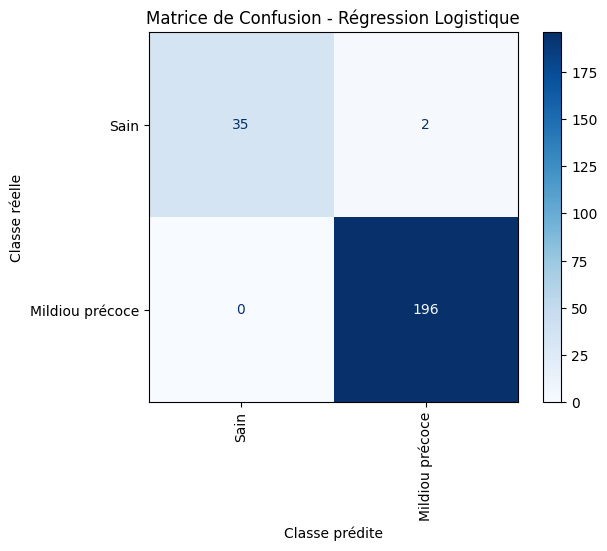

In [ ]:
# Retirer la classe 1 du jeu de données
X_train0 = X_train[y_train != 1]
y_train0 = y_train[y_train != 1]
X_test0 = X_test[y_test != 1]
y_test0 = y_test[y_test != 1]
# Normaliser les données d'entrainement et de validation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train0)
X_test_scaled = scaler.transform(X_test0)

# Créer des étiquettes binaires pour la méthode un contre tous
y_train_binary = np.where(y_train0 == 2, 0, 1)
y_test_binary = np.where(y_test0 == 2, 0, 1)

# Créer un modèle de régression logistique
model_rl = LogisticRegression(max_iter=200)  # Augmenter le nombre d'itérations

# Entraîner le modèle
model_rl.fit(X_train_scaled, y_train_binary)

# Prédire sur l'ensemble de validation
y_test_pred = model_rl.predict(X_test_scaled)

# Évaluer la précision
accuracy = accuracy_score(y_test_binary, y_test_pred)
print("Précision du modèle de régression logistique :", accuracy)

# Afficher le rapport de classification
print("\nRapport de classification :\n", classification_report(y_test_binary, y_test_pred))

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Sain','Mildiou précoce' ])
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Matrice de Confusion - Régression Logistique")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


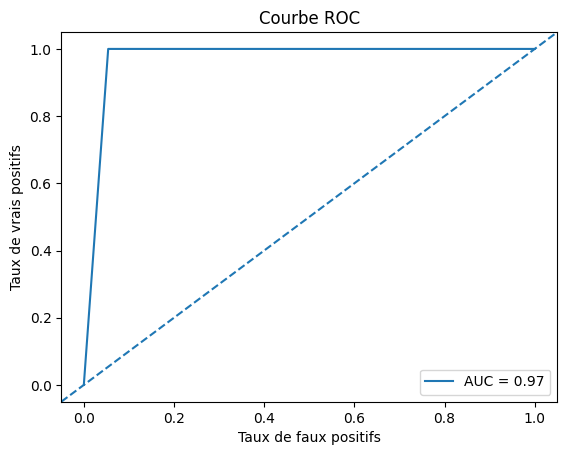

TFP :  [0.         0.05405405 1.        ]


In [ ]:
# Courbe ROC avec mildiou précoce/sain
fpr,tpr,_=roc_curve(y_test_binary,y_test_pred)
roc_auc=auc(fpr,tpr)
plt.figure()
plt.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc)
plt.axline((0,0),slope=1,linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()
print("TFP : ", fpr)